# 6-1. 프로젝트: 인물 모드 문제점 찾기

만들면서 뭔가 이상한 점이 느껴지지 않으셨나요? 프로젝트를 통해 찾아봅시다.

우선 주요 라이브러리 버전을 확인해 볼까요?

In [1]:
# os: Operating System의 줄임말로, 운영체제에서 제공되는 여러 기능을 파이썬에서 사용할 수 있도록 함 (Ex. 디렉토리 경로 이동, 시스템 환경 변수 가져오기 등)
# urllib: URL 작업을 위한 여러 모듈을 모은 패키지. (Ex. urllib.request, urllib.parse, ...)
# cv2: OpenCV 라이브러리로, 실시간 컴퓨터 비전을 목적으로 한 프로그래밍 라이브러리
# numpy(NumPy): 행렬이나 대규모 다차원 배열을 쉽게 처리할 수 있도록 지원하는 라이브러리. 데이터 구조 외에도 수치 계산을 위해 효율적으로 구현된 기능을 제공
# pixellib: 이미지 및 비디오 segmentation을 수행하기 위한 라이브러리. 
# pixellib.semantic: segmentation 기법 중, semantic segmentation을 쉽게 사용할 수 있도록 만든 라이브러리
# matplotlib: 파이썬 프로그래밍 언어 및 수학적 확장 NumPy 라이브러리를 활용한 플로팅 라이브러리로, 데이터 시각화 도구
# importlib.metadata: 설치된 패키지 메타 데이터에 대한 접근을 제공하는 라이브러리.
# 해당 코드 블럭에서는 importlib.metadata 안에 있는 version() 함수를 이용하여 pixellib 라이브러리의 버전을 확인

import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt
from importlib.metadata import version

print(cv2.__version__)
print(version('pixellib'))

4.5.3
0.7.1


Step 1. 인물모드 직접 해 보기

여러분의 셀카를 이용해서 오늘 배운 내용을 수행해 봅시다. 아래와 같은 이미지를 얻어야 합니다. 최소 3장 이상의 인물모드 사진을 만들어 봅시다.
인물이 주인공이 아닌, 귀여운 고양이에 대한 아웃포커싱 사진도 만들어 볼 수 있을 것입니다. 시맨틱 세그멘테이션 스텝에서 힌트를 찾아봅시다.
배경을 blur하는 인물모드 사진이 아니라 배경사진을 다른 이미지로 교체하는 크로마키 배경 합성을 시도해 볼 수도 있을 것입니다. 여러분만의 환상적인 사진을 만들어 보면 어떨까요?

(512, 745, 3)
(792, 720, 3)
(360, 540, 3)


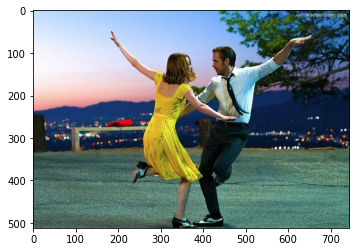

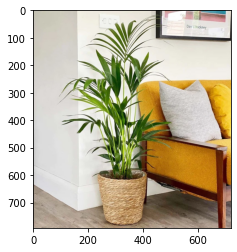

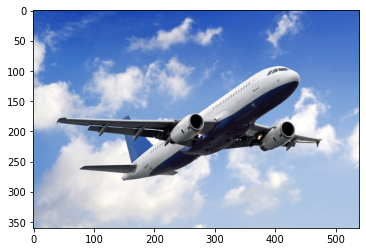

In [313]:
# os 모듈에 있는 getenv() 함수를 이용하여 읽고싶은 파일의 경로를 file_path에 저장
# 준비한 이미지 파일의 경로를 이용하여, 이미지 파일을 읽음
# cv2.imread(경로): 경로에 해당하는 이미지 파일을 읽어서 변수에 저장
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/movie.jpeg'  
img_orig = cv2.imread(img_path)

img_pottedplant_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/pottedplant.jpeg'
img_pottedplant = cv2.imread(img_cat_path)

img_air_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/aeroplane.jpeg' 
img_air = cv2.imread(img_air_path) 

print(img_orig.shape)
print(img_pottedplant.shape)
print(img_air.shape)

# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 이미지 색상 채널을 변경 (BGR 형식을 RGB 형식으로 변경)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시, 입력은 RGB(A) 데이터 혹은 2D 스칼라 데이터
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html
# plt.show(): 현재 열려있는 모든 figure를 표시 (여기서 figure는 이미지, 그래프 등)
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.show.html
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(img_pottedplant, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(img_air, cv2.COLOR_BGR2RGB))
plt.show()

In [314]:
# 저장할 파일 이름을 결정합니다
# 1. os.getenv(x)함수는 환경 변수x의 값을 포함하는 문자열 변수를 반환합니다. model_dir 에 "/aiffel/human_segmentation/models" 저장
# 2. #os.path.join(a, b)는 경로를 병합하여 새 경로 생성 model_file 에 "/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5" 저장
# 1
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
# 2
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file) # urllib 패키지 내에 있는 request 모듈의 urlretrieve 함수를 이용해서 model_url에 있는 파일을 다운로드 해서 model_file 파일명으로 저장

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f0e0cfff670>)

In [315]:
model = semantic_segmentation() #PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
model.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출

In [316]:
segvalues, output = model.segmentAsPascalvoc(img_path)

In [317]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

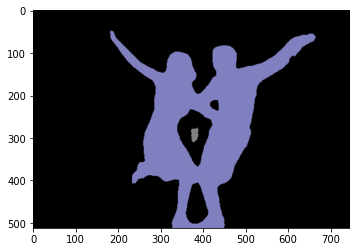

In [318]:
#segmentAsPascalvoc() 함수 를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 output을 matplotlib을 이용해 출력
plt.imshow(output)
plt.show()

In [319]:
#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
car
person


In [320]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!

#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [321]:
colormap[15] #컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)

array([192, 128, 128])

In [322]:
seg_color = (128,128,192) # 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치가 되어 있어서

(512, 745)


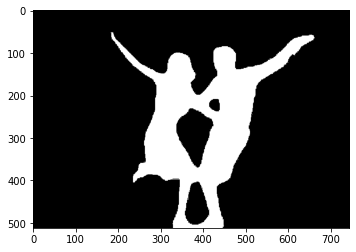

In [323]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
# seg_color 값이 person을 값이 므로 사람이 있는 위치를 제외하고는 gray로 출력
# cmap 값을 변경하면 다른 색상으로 확인이 가능함
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

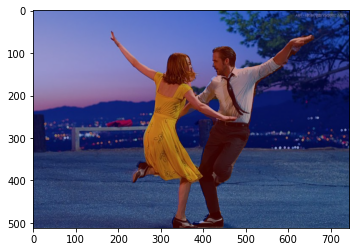

In [324]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

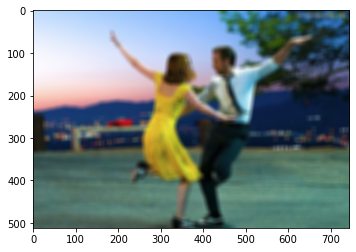

In [325]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (13,13))

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)   
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

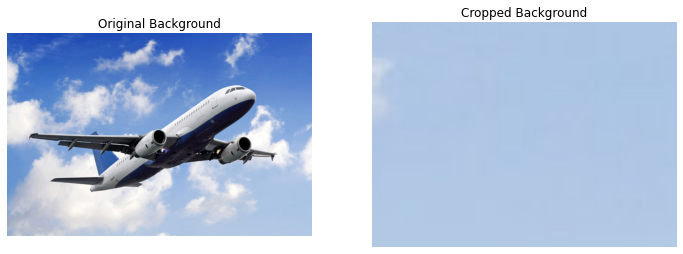

In [354]:
# 배경 이미지의 크기를 가져옵니다.
height_bg, width_bg = img_air.shape[:2]

# 타겟 이미지의 크기를 가져옵니다. (이전에 이미 불러왔던 img_orig에서)
height, width = img_orig.shape[:2]

# 배경 이미지를 타겟 이미지의 크기에 맞게 크롭합니다.
# 중앙에서부터 크롭을 시작합니다.
start_x = (width_bg - width) // 2
start_y = (height_bg - height) // 2
end_x = start_x + width
end_y = start_y + height

# 실제로 크롭을 수행합니다.
cropped_background = img_air[start_y:end_y, start_x:end_x]

# 결과를 확인합니다.
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Background")
plt.imshow(cv2.cvtColor(img_back, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Cropped Background")
plt.imshow(cv2.cvtColor(cropped_background, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

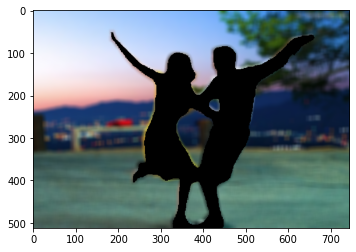

In [327]:
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0입니다.
img_bg_mask = cv2.bitwise_not(img_mask_color)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

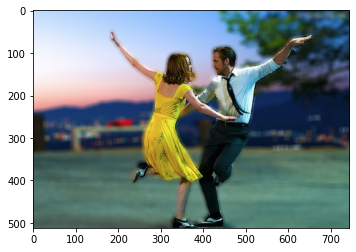

In [328]:
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다.
img_concat1 = np.where(img_mask_color==255, img_orig, img_orig_blur)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(img_concat1, cv2.COLOR_BGR2RGB))
plt.show()

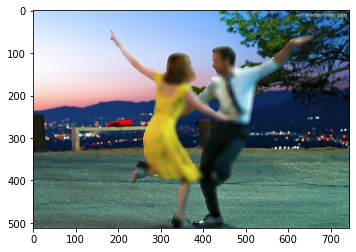

In [329]:
# Q. 이번에는 사람 부분을 블러로, 배경 부분을 원본으로 출력해볼까요?
# 힌트 : img_mask_color 옵션을 적절히 조정해주고, img_orig, img_orig_blur 를 활용하세요.
img_concat2 = np.where(img_mask_color == 255, img_orig_blur, img_orig)
plt.imshow(cv2.cvtColor(img_concat2, cv2.COLOR_BGR2RGB))
plt.show()

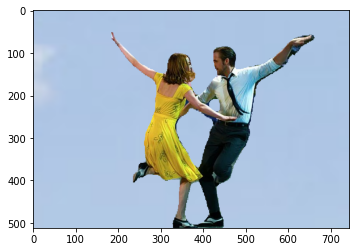

In [330]:
#배경을 변경
cropped_background_resized = cv2.resize(cropped_background, (img_mask_color.shape[1], img_mask_color.shape[0]))
img_concat3 = np.where(img_mask_color == 255, img_orig, cropped_background_resized)
plt.imshow(cv2.cvtColor(img_concat3, cv2.COLOR_BGR2RGB))
plt.show()

In [331]:
segvalues2, output2 = model.segmentAsPascalvoc(img_pottedplant_path)

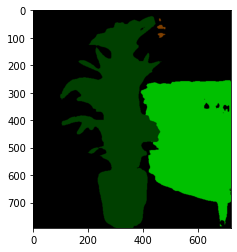

In [332]:
#segmentAsPascalvoc() 함수 를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 output을 matplotlib을 이용해 출력
plt.imshow(output2)
plt.show()

In [333]:
#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues2['class_ids']:
    print(LABEL_NAMES[class_id])

background
pottedplant
sofa
tv


In [334]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!

#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [335]:
colormap[5] #컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 17번째인 양)

array([128,   0, 128])

In [336]:
seg_color2 = (0,64,0) # 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치가 되어 있어서

(792, 720)


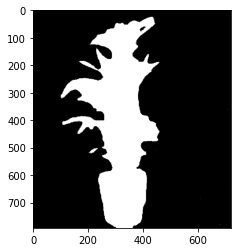

In [337]:
seg_map2 = np.all(output2==seg_color2, axis=-1) 
print(seg_map2.shape) 
plt.imshow(seg_map2, cmap='gray')
plt.show()

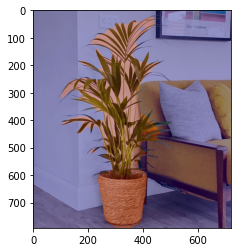

In [338]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show2 = img_pottedplant.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask2 = seg_map2.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask2 = cv2.applyColorMap(img_mask2, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show2 = cv2.addWeighted(img_show2, 0.6, color_mask2, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show2, cv2.COLOR_BGR2RGB))
plt.show()

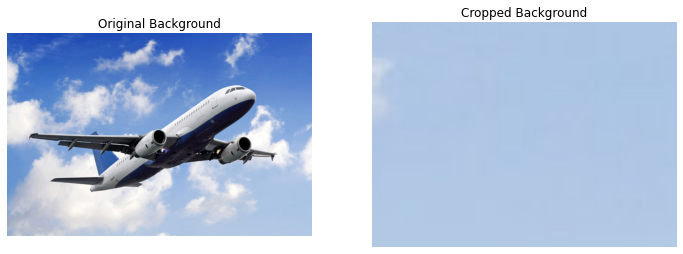

In [355]:
# 배경 이미지의 크기를 가져옵니다.
height_bg, width_bg = img_air.shape[:2]

# 타겟 이미지의 크기를 가져옵니다. (이전에 이미 불러왔던 img_sheep에서)
height, width = img_pottedplant.shape[:2]

# 배경 이미지를 타겟 이미지의 크기에 맞게 크롭합니다.
# 중앙에서부터 크롭을 시작합니다.
start_x = (width_bg - width) // 2
start_y = (height_bg - height) // 2
end_x = start_x + width
end_y = start_y + height

# 실제로 크롭을 수행합니다.
cropped_background2 = img_air[start_y:end_y, start_x:end_x]

# 결과를 확인합니다.
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Background")
plt.imshow(cv2.cvtColor(img_back, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Cropped Background")
plt.imshow(cv2.cvtColor(cropped_background, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

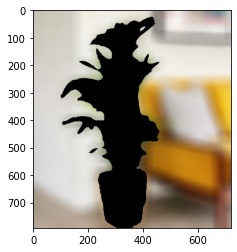

In [356]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_pottedplant_blur = cv2.blur(img_pottedplant, (50,50))

# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
img_mask_color2 = cv2.cvtColor(img_mask2, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0입니다.
img_bg_mask2 = cv2.bitwise_not(img_mask_color2)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
img_bg_blur2 = cv2.bitwise_and(img_pottedplant_blur, img_bg_mask2)
plt.imshow(cv2.cvtColor(img_bg_blur2, cv2.COLOR_BGR2RGB))
plt.show()

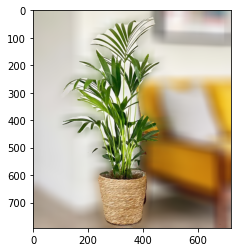

In [357]:
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다.
img_concat4 = np.where(img_mask_color2==255, img_pottedplant, img_pottedplant_blur)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(img_concat4, cv2.COLOR_BGR2RGB))
plt.show()

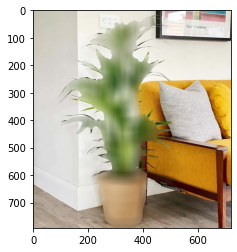

In [358]:
#식물 블러
img_concat5 = np.where(img_mask_color2 == 255, img_pottedplant_blur, img_pottedplant)
plt.imshow(cv2.cvtColor(img_concat5, cv2.COLOR_BGR2RGB))
plt.show()

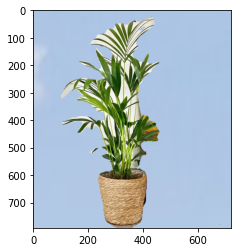

In [359]:
#배경을 변경
img_pottedplant_resized = cv2.resize(img_pottedplant, (img_mask_color2.shape[1], img_mask_color2.shape[0]))
cropped_background_resized = cv2.resize(cropped_background_resized, (img_mask_color2.shape[1], img_mask_color2.shape[0]))
img_concat6 = np.where(img_mask_color2 == 255, img_pottedplant_resized, cropped_background_resized)
plt.imshow(cv2.cvtColor(img_concat6, cv2.COLOR_BGR2RGB))
plt.show()

In [367]:
# 가상의 img_concat1 이미지를 저장할 경로를 지정합니다.
# 실제 코드에서는 이미 생성된 img_concat1 이미지를 이용하게 됩니다.
img_concat1_save_path = '/aiffel/outfocus1.jpg'

# 이미지를 저장합니다.
try:
    cv2.imwrite(img_concat1_save_path, img_concat1)
    print(f"Image saved at {img_concat1_save_path}")
except Exception as e:
    print(f"An error occurred: {e}")


# 저장된 이미지 파일의 경로를 반환합니다.
img_concat1_save_path

Image saved at /aiffel/outfocus1.jpg


'/aiffel/outfocus1.jpg'

In [370]:
# 가상의 img_concat4 이미지를 저장할 경로를 지정합니다.
# 실제 코드에서는 이미 생성된 img_concat5 이미지를 이용하게 됩니다.
img_concat4_save_path = '/aiffel/outfocus3.jpg'

# 이미지를 저장합니다.
try:
    cv2.imwrite(img_concat1_save_path, img_concat4)
    print(f"Image saved at {img_concat5_save_path}")
except Exception as e:
    print(f"An error occurred: {e}")


# 저장된 이미지 파일의 경로를 반환합니다.
img_concat5_save_path

Image saved at /aiffel/outfocus2.jpg


'/aiffel/outfocus2.jpg'

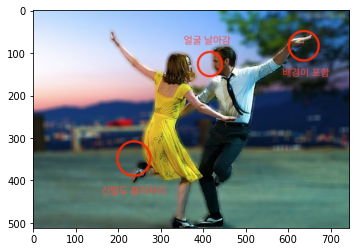

In [371]:
img_fault_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/outfocus.jpg' 
img_fault = cv2.imread(img_fault_path) 
plt.imshow(cv2.cvtColor(img_fault, cv2.COLOR_BGR2RGB))
plt.show()

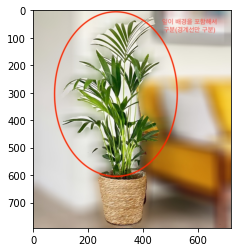

In [372]:
img_fault_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/outfocus1.jpg' 
img_fault = cv2.imread(img_fault_path) 
plt.imshow(cv2.cvtColor(img_fault, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
#문제점

### 사람의 경우 경계를 포함하여 구분하거나 제외하고 구분하는 케이스 발생

### 다소 복잡하고 공백을 포함한 식물의 경우 배경을 포함하여 구분함